#### Hand Sign Recognition -> It is a MultiClass Classification hence we will be using the MLP as our model architecture

# Imports

In [1]:
from numpy.random import seed
seed(888)
from tensorflow.random import set_seed
set_seed(404)

In [2]:
import os
import numpy as np
import cv2

import tensorflow as tf

from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Flatten
from tensorflow.keras.callbacks import TensorBoard

from time import strftime

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

# Constants

In [4]:
train_dir_digits = './Sign-Language-Digits-Dataset/Dataset/'
test_dir_digits = './Sign-Language-Digits-Dataset/Examples/'

classes = ['0','1','2','3','4','5','6','7','8','9']

IMAGE_WIDTH=64
IMAGE_HEIGHT=64
IMAGE_PIXELS = IMAGE_HEIGHT * IMAGE_WIDTH
COLOR_CHANNELS = 3
TOTAL_INPUTS = IMAGE_PIXELS * COLOR_CHANNELS
VALIDATION_SIZE=10000
VALIDATION_RATIO=0.2
LOGGING_PATH = 'tensorboard_hand-sign_digit_logs/'

NR_CLASSES = len(classes)

# A Look At The Data

## The Digits

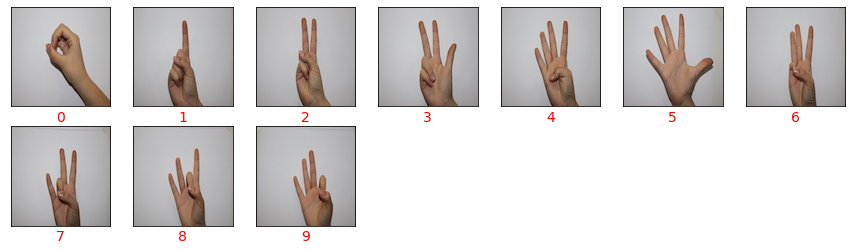

In [5]:
plt.figure(figsize=(15, 15))
for i in range (0,10):
    plt.subplot(7,7,i+1)
    plt.xticks([])
    plt.yticks([])
    path = train_dir_digits + "{0}/".format(classes[i])
    data = os.listdir(path)
    path = path + data[0]
    img = plt.imread(path)
    plt.imshow(img)
    label = plt.xlabel(classes[i], fontsize=14)
    label.set_color("red")


# Get The Data

In [6]:
def load_data(train_dir):
    images = []
    labels = []
    size = IMAGE_HEIGHT,IMAGE_WIDTH
    for directory in os.listdir(train_dir):
        for image in os.listdir(train_dir + "/" + directory):
            img = cv2.imread(train_dir + '/' + directory + '/' + image)
            final_img = cv2.resize(img, size)
            images.append(final_img)
            idx = int(directory)
            labels.append(idx)
        print('loaded:', directory, 'label:', idx)
    images = np.array(images)
    labels = utils.to_categorical(labels)
    
    return images,labels

In [7]:
%%time

images,labels = load_data(train_dir_digits)

loaded: 0 label: 0
loaded: 1 label: 1
loaded: 2 label: 2
loaded: 3 label: 3
loaded: 4 label: 4
loaded: 5 label: 5
loaded: 6 label: 6
loaded: 7 label: 7
loaded: 8 label: 8
loaded: 9 label: 9
Wall time: 1.26 s


# Exlpore The Data

In [9]:
nr_images, x, y, c = images.shape
print(f'images = {nr_images} \t| width = {x} \t| height = {y} \t| channels = {c}')

images = 2062 	| width = 64 	| height = 64 	| channels = 3


# Data Preprocessing 

In [10]:
images = images.astype('float32')/255.0

In [11]:
images[0][0][0]

array([0.7058824, 0.7058824, 0.7058824], dtype=float32)

In [12]:
labels.shape

(2062, 10)

In [13]:
images.shape

(2062, 64, 64, 3)

In [14]:
labels[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [15]:
# images = images.reshape(images.shape[0], *(IMAGE_HEIGHT, IMAGE_WIDTH, 1))

In [16]:
images.shape

(2062, 64, 64, 3)

# Train Test Split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size = 0.1)

In [18]:
X_train.shape

(1855, 64, 64, 3)

In [19]:
# X_train = X_train[:, 1:]
# y_train = y_test[:, 0]
# X_test = X_test[:, 1:]
# y_test = y_test[:, 0]

In [20]:
X_test.shape

(207, 64, 64, 3)

In [21]:
y_test.shape

(207, 10)

In [22]:
# X_train = X_train.reshape(X_train[0][0].shape, IMAGE_PIXELS)

# Create Validation Dataset

In [23]:
# X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size = 0.2, random_state = 1024)

In [24]:
# X_train.shape

In [25]:
# X_validate.shape

# Tensorflow Architecture Setup

#### Hyperparameters

In [46]:
nr_epochs = 25
learning_rate = 1e-3

#### Defining the model

In [41]:
mlp = Sequential()

mlp.add(Conv2D(32, (3,3), padding = 'same', activation = 'relu',
               input_shape = (IMAGE_HEIGHT,IMAGE_WIDTH, COLOR_CHANNELS)))
mlp.add(MaxPooling2D(pool_size = (2, 2)))
# mlp.add(Dropout(0.25))

mlp.add(Conv2D(64 , (3,3), padding = 'same', activation = 'relu',
               input_shape = (IMAGE_HEIGHT,IMAGE_WIDTH, COLOR_CHANNELS)))
mlp.add(MaxPooling2D(pool_size = (2, 2)))
# mlp.add(Dropout(0.25))

mlp.add(Conv2D(128 , (3,3), padding = 'same', activation = 'relu',
               input_shape = (IMAGE_HEIGHT,IMAGE_WIDTH, COLOR_CHANNELS)))
# mlp.add(Dropout(0.25))

mlp.add(Flatten())

mlp.add(Dense(units = 512, activation = 'relu'))
mlp.add(Dropout(0.25))
mlp.add(Dense(1024, activation='sigmoid'))
mlp.add(Dense(NR_CLASSES, activation='softmax'))

In [42]:
mlp.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)              

# Tensorboard Setup

In [43]:
def get_tensorboard(model_name):
    folder_name = f'{model_name} at {strftime("%H %M")}'
    dir_paths = os.path.join(LOGGING_PATH, folder_name)
    try:
        os.makedirs(dir_paths)
    except OSError as err:
        print(err.strerror)
    else:
        print('Successfully created directory')
    return TensorBoard(log_dir=dir_paths, histogram_freq=1)

# Train The Model

### Compile

In [44]:
adam = Adam(lr=learning_rate)

mlp.compile(loss ='categorical_crossentropy', optimizer=adam ,metrics =['accuracy'])

### Train

In [45]:
# history = mlp.fit(X_train, y_train, batch_size = 64, epochs = nr_epochs, verbose = 1,
#                   validation_data = (X_validate, y_validate), callbacks=[get_tensorboard('Model 1 MLP-VAL')])
history = mlp.fit(X_train, y_train, batch_size=64, epochs=nr_epochs, validation_split=0.1, shuffle = True, verbose=1,
                  callbacks=[get_tensorboard('Model 1 MLP-VAL')])

Successfully created directory
Epoch 1/50
27/27 [==============================] - 3s 69ms/step - loss: 2.4491 - accuracy: 0.0930 - val_loss: 2.3260 - val_accuracy: 0.0968
Epoch 2/50
27/27 [==============================] - 0s 17ms/step - loss: 2.3429 - accuracy: 0.1124 - val_loss: 2.3345 - val_accuracy: 0.1398
Epoch 3/50
27/27 [==============================] - 0s 18ms/step - loss: 2.3376 - accuracy: 0.1133 - val_loss: 2.3468 - val_accuracy: 0.0914
Epoch 4/50
27/27 [==============================] - 0s 17ms/step - loss: 2.3136 - accuracy: 0.0963 - val_loss: 1.9425 - val_accuracy: 0.3011
Epoch 5/50
27/27 [==============================] - 0s 18ms/step - loss: 1.4287 - accuracy: 0.4799 - val_loss: 0.7711 - val_accuracy: 0.7688
Epoch 6/50
27/27 [==============================] - 0s 17ms/step - loss: 0.6776 - accuracy: 0.7665 - val_loss: 0.5590 - val_accuracy: 0.8333
Epoch 7/50
27/27 [==============================] - 0s 17ms/step - loss: 0.4714 - accuracy: 0.8456 - val_loss: 0.3718 - val

In [38]:
# %load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
tensorboard_hand-sign_digit_logs/Model 1 MLP-VAL at 23 38


In [39]:
# dir_paths = os.path.join(LOGGING_PATH, 'Model 1 MLP-VAL at 23 38')
# %tensorboard --logdir LOGGING_PATH

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 15856.